<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/Copy_of_lab_gan_todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN + conditional DCGAN


Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020). Updated by [Mariona Carós](https://es.linkedin.com/in/mariona-c-a7bb91105) in 2022.
Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) during 2022.

In this notebook you will learn about Generative Adversarial Networks by implementing a DCGAN to generate images from noise.

**Important:** Set the Colab environment to run on GPU

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

In [ ]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [ ]:
hparams = {
    'batch_size':128,
    'num_epochs':20,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':100,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':1,
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transforms,
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.40MB/s]


# DCGAN

First, lets define our simple generator network.

### Exercise 1: Generator

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, noise_size: int, num_input_channels: int):
        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 4 * 4)

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(x.shape[0], 512, 4, 4) # (B, channels, height, width)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

Similarly, let's define a simple discriminator

### Exercise 2: Discriminator

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self, num_input_channels: int):
        super().__init__()

        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.shape[0], -1) # (B, channels * height * width)
        x = self.fc(x)

        return x

In [ ]:
generator = Generator(hparams['noise_size'], hparams['num_input_channels']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

discriminator = Discriminator(hparams['num_input_channels']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

### Exercise 3: Train

Complete the code. Take into account which labels should be used at each step of the training.

In [ ]:
def train_batch(
        real_samples: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_samples = generator(z)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples)
    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights (do a step in the optimizer)
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach() # Let's detach them to freeze the generator

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    # Update weights (do a step in the optimizer)
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 3.130373001098633, D_loss: 0.09354285895824432


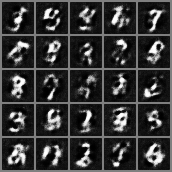


Epoch: 1/20, batch: 400/469, G_loss: 3.072195053100586, D_loss: 0.08982221782207489


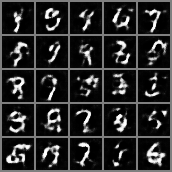


Epoch: 1/20, batch: 469/469, G_loss: 2.273446559906006, D_loss: 0.34183043241500854


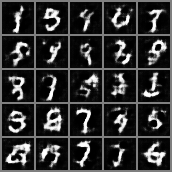


Epoch: 2/20, batch: 200/469, G_loss: 3.160283088684082, D_loss: 0.09481208026409149


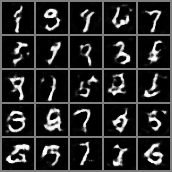


Epoch: 2/20, batch: 400/469, G_loss: 4.334923267364502, D_loss: 0.5678380131721497


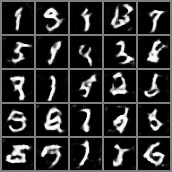


Epoch: 2/20, batch: 469/469, G_loss: 2.019540548324585, D_loss: 0.1096193790435791


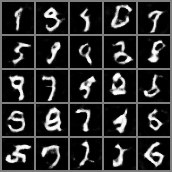


Epoch: 3/20, batch: 200/469, G_loss: 2.058098316192627, D_loss: 0.15433213114738464


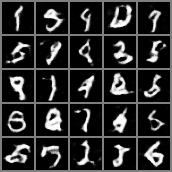


Epoch: 3/20, batch: 400/469, G_loss: 4.1423234939575195, D_loss: 0.6969408988952637


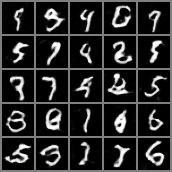


Epoch: 3/20, batch: 469/469, G_loss: 1.9406946897506714, D_loss: 0.23980361223220825


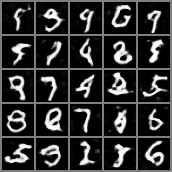


Epoch: 4/20, batch: 200/469, G_loss: 2.440289258956909, D_loss: 0.08254256099462509


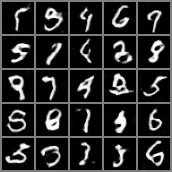


Epoch: 4/20, batch: 400/469, G_loss: 2.9980356693267822, D_loss: 0.33737725019454956


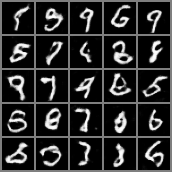


Epoch: 4/20, batch: 469/469, G_loss: 2.2815098762512207, D_loss: 0.10691976547241211


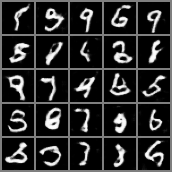


Epoch: 5/20, batch: 200/469, G_loss: 2.089198589324951, D_loss: 0.13168807327747345


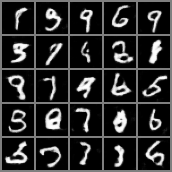


Epoch: 5/20, batch: 400/469, G_loss: 8.969249725341797, D_loss: 1.4021339416503906


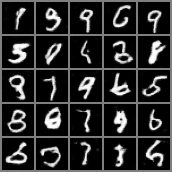


Epoch: 5/20, batch: 469/469, G_loss: 2.6144628524780273, D_loss: 0.08228664100170135


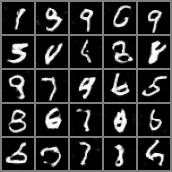


Epoch: 6/20, batch: 200/469, G_loss: 3.584217071533203, D_loss: 0.07301011681556702


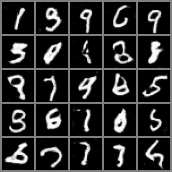


Epoch: 6/20, batch: 400/469, G_loss: 1.771628737449646, D_loss: 0.1936054676771164


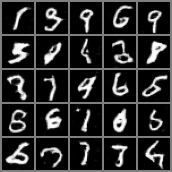


Epoch: 6/20, batch: 469/469, G_loss: 2.586862802505493, D_loss: 0.07055361568927765


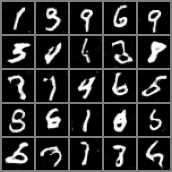


Epoch: 7/20, batch: 200/469, G_loss: 4.9386467933654785, D_loss: 0.020423205569386482


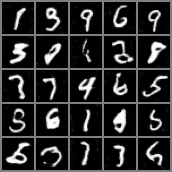


Epoch: 7/20, batch: 400/469, G_loss: 1.6355972290039062, D_loss: 0.19249626994132996


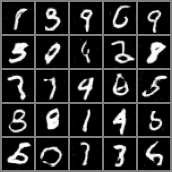


Epoch: 7/20, batch: 469/469, G_loss: 1.7015082836151123, D_loss: 0.20231088995933533


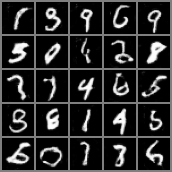


Epoch: 8/20, batch: 200/469, G_loss: 3.300342082977295, D_loss: 0.06841685622930527


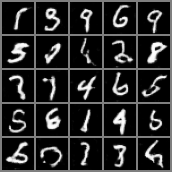


Epoch: 8/20, batch: 400/469, G_loss: 5.077165603637695, D_loss: 0.010676605626940727


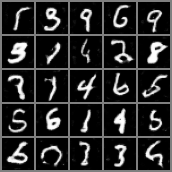


Epoch: 8/20, batch: 469/469, G_loss: 4.941542625427246, D_loss: 0.015223643742501736


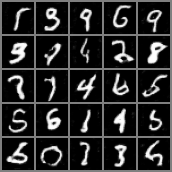


Epoch: 9/20, batch: 200/469, G_loss: 0.8820817470550537, D_loss: 0.5351161360740662


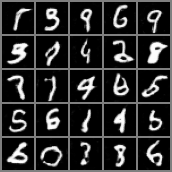


Epoch: 9/20, batch: 400/469, G_loss: 3.5911459922790527, D_loss: 0.2924853265285492


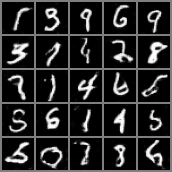


Epoch: 9/20, batch: 469/469, G_loss: 2.8146395683288574, D_loss: 0.06294596940279007


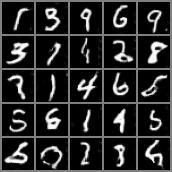


Epoch: 10/20, batch: 200/469, G_loss: 4.895471572875977, D_loss: 0.012381648644804955


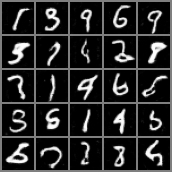


Epoch: 10/20, batch: 400/469, G_loss: 5.147753715515137, D_loss: 0.011076325550675392


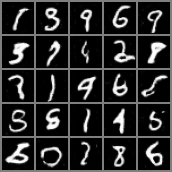


Epoch: 10/20, batch: 469/469, G_loss: 6.075540065765381, D_loss: 0.006942725274711847


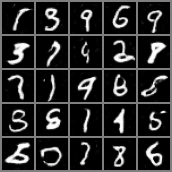


Epoch: 11/20, batch: 200/469, G_loss: 1.034290075302124, D_loss: 0.4191802144050598


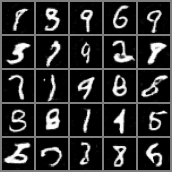


Epoch: 11/20, batch: 400/469, G_loss: 1.0885744094848633, D_loss: 0.6836602091789246


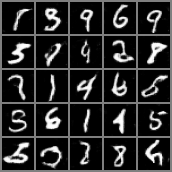


Epoch: 11/20, batch: 469/469, G_loss: 1.272124171257019, D_loss: 0.2825373113155365


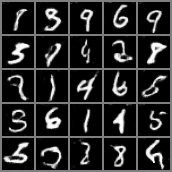


Epoch: 12/20, batch: 200/469, G_loss: 2.577416181564331, D_loss: 0.08245991170406342


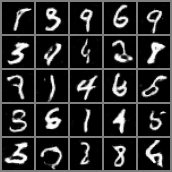


Epoch: 12/20, batch: 400/469, G_loss: 5.764430046081543, D_loss: 0.007206041365861893


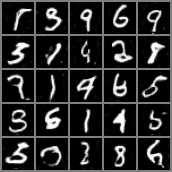


Epoch: 12/20, batch: 469/469, G_loss: 3.3709540367126465, D_loss: 0.03702713921666145


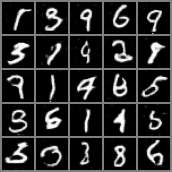


Epoch: 13/20, batch: 200/469, G_loss: 5.42714786529541, D_loss: 0.006264989264309406


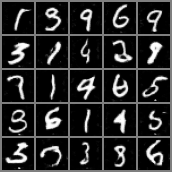


Epoch: 13/20, batch: 400/469, G_loss: 5.617815971374512, D_loss: 0.005457222927361727


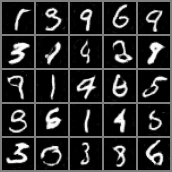


Epoch: 13/20, batch: 469/469, G_loss: 6.84229040145874, D_loss: 0.006644441746175289


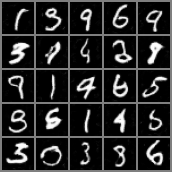


Epoch: 14/20, batch: 200/469, G_loss: 6.626222133636475, D_loss: 0.0031723948195576668


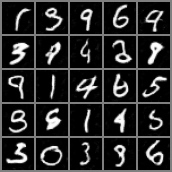


Epoch: 14/20, batch: 400/469, G_loss: 6.671842098236084, D_loss: 0.0031935125589370728


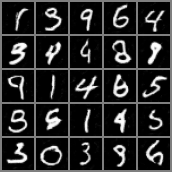


Epoch: 14/20, batch: 469/469, G_loss: 7.729440689086914, D_loss: 0.003957953304052353


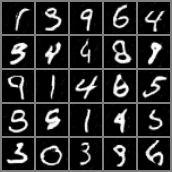


Epoch: 15/20, batch: 200/469, G_loss: 0.8656282424926758, D_loss: 0.5148812532424927


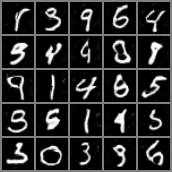


Epoch: 15/20, batch: 400/469, G_loss: 4.631894111633301, D_loss: 0.7187230587005615


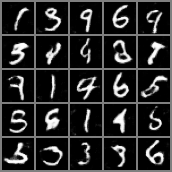


Epoch: 15/20, batch: 469/469, G_loss: 2.602936267852783, D_loss: 0.2830032706260681


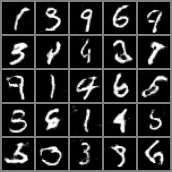


Epoch: 16/20, batch: 200/469, G_loss: 2.2488279342651367, D_loss: 0.1881733238697052


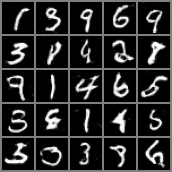


Epoch: 16/20, batch: 400/469, G_loss: 3.501175880432129, D_loss: 0.05288020148873329


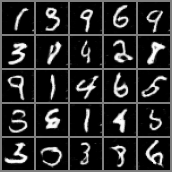


Epoch: 16/20, batch: 469/469, G_loss: 2.4672133922576904, D_loss: 0.08729960769414902


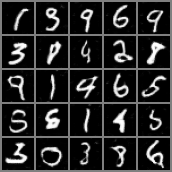


Epoch: 17/20, batch: 200/469, G_loss: 6.082963466644287, D_loss: 0.01326623372733593


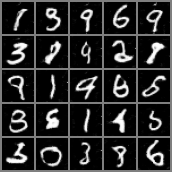


Epoch: 17/20, batch: 400/469, G_loss: 5.749860763549805, D_loss: 0.006620179396122694


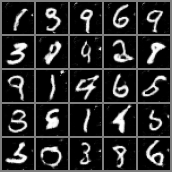


Epoch: 17/20, batch: 469/469, G_loss: 5.264667987823486, D_loss: 0.01097026001662016


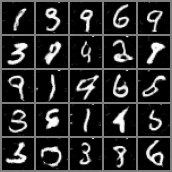


Epoch: 18/20, batch: 200/469, G_loss: 6.036983489990234, D_loss: 0.007910589687526226


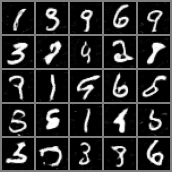


Epoch: 18/20, batch: 400/469, G_loss: 5.921957492828369, D_loss: 0.0044825999066233635


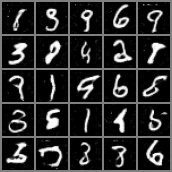


Epoch: 18/20, batch: 469/469, G_loss: 5.587502479553223, D_loss: 0.00604536198079586


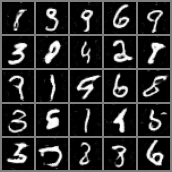


Epoch: 19/20, batch: 200/469, G_loss: 6.915378570556641, D_loss: 0.002890095580369234


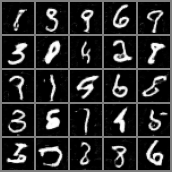


Epoch: 19/20, batch: 400/469, G_loss: 6.912593841552734, D_loss: 0.0027070266660302877


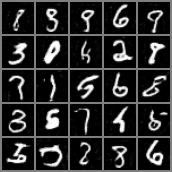


Epoch: 19/20, batch: 469/469, G_loss: 6.9275126457214355, D_loss: 0.0016161090461537242


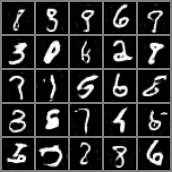


Epoch: 20/20, batch: 200/469, G_loss: 1.7053614854812622, D_loss: 0.25270915031433105


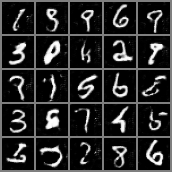


Epoch: 20/20, batch: 400/469, G_loss: 1.5290478467941284, D_loss: 0.35232338309288025


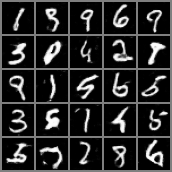


Epoch: 20/20, batch: 469/469, G_loss: 1.1348567008972168, D_loss: 0.3473512828350067


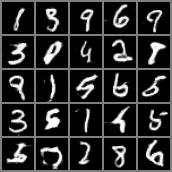

In [ ]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  +f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate(generator, z_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
          +f" G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate(generator, z_val)
    display(fake_images)


# Extra: Conditional GAN

### Exercise 4: Generator

We will now modify the generator from before to a conditional generator. To do it, we will concatenate the input to the convolutions with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
class ConditionalGenerator(torch.nn.Module):

    def __init__(
            self,
            noise_size: int,
            num_input_channels: int,
            num_classes: int
            ) -> None:

        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 4 * 4)

        # Embedding of the class
        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=4*4,
        )

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 1, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )


        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        # x: (B, noise_size)
        # label: (B,)

        B = x.size(0)

        # Noise to feature map
        x = self.fc(x)                  # (B, 512*4*4)
        x = x.reshape(B, 512, 4, 4)     # (B, 512, 4, 4)

        # Label embedding as spatial map
        emb = self.embedding(label)     # (B, 16)
        emb = emb.reshape(B, 1, 4, 4)   # (B, 1, 4, 4)

        # Concatenate label as an extra channel
        x = torch.cat((x, emb), dim=1)  # (B, 513, 4, 4)

        # Generator blocks
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

### Exercise 5: Discriminator

We will now modify the discriminator from before to a conditional discriminator. To do it, we will concatenate the input image with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
import torch
import torch.nn as nn

class ConditionalDiscriminator(torch.nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 num_classes: int):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=32 * 32,
        )

        # (B, C+1, 32, 32) -> (B, 128, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels + 1, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        )

        # (B, 128, 16, 16) -> (B, 256, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # (B, 256, 8, 8) -> (B, 512, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Flatten (512*4*4) -> 1
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(),  # Binary classification (real vs fake)
        )

    def forward(self, x: torch.Tensor, label) -> torch.Tensor:
        # x: (B, num_input_channels, 32, 32)
        # label: int or (B,) tensor

        B = x.size(0)

        # Make label a (B,) LongTensor on the same device
        if isinstance(label, int):
            label = torch.full((B,), label, dtype=torch.long, device=x.device)
        else:
            label = label.to(device=x.device, dtype=torch.long).view(-1)

        # Embed label and reshape to a 1-channel 32x32 map
        emb = self.embedding(label).reshape(B, 1, 32, 32)  # (B, 1, 32, 32)

        # Concatenate as a new channel
        x = torch.cat((x, emb), dim=1)  # (B, num_input_channels+1, 32, 32)

        # Convs
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.reshape(B, -1)  # (B, 512*4*4)

        # FC
        x = self.fc(x)        # (B, 1)

        return x


In [ ]:
generator = ConditionalGenerator(hparams['noise_size'], hparams['num_input_channels'],
                                 hparams['num_classes']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'],
                               betas=hparams['betas'])

discriminator = ConditionalDiscriminator(hparams['num_input_channels'],hparams['num_classes']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

In [ ]:
def train_batch_conditional(
        real_samples: torch.Tensor,
        real_classes: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_classes = torch.randint(0, 10, size=(bsz, 1), device=device)
    fake_samples = generator(z, fake_classes)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach()

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward()

    # Update weights
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate_conditional(
        generator: torch.nn.Module,
        z_val: torch.Tensor,
        labels_val: torch.Tensor,
        ) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 3.2295451164245605, D_loss: 0.12193717062473297


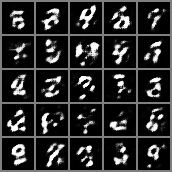


Epoch: 1/20, batch: 400/469, G_loss: 3.7418720722198486, D_loss: 0.06994570046663284


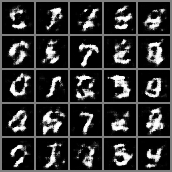


Epoch: 1/20, batch: 469/469, G_loss: 1.5540484189987183, D_loss: 0.3568851947784424


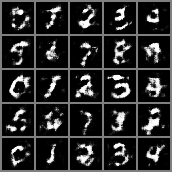


Epoch: 2/20, batch: 200/469, G_loss: 3.1700336933135986, D_loss: 0.10557493567466736


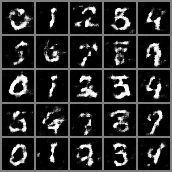


Epoch: 2/20, batch: 400/469, G_loss: 2.324718713760376, D_loss: 0.2144230753183365


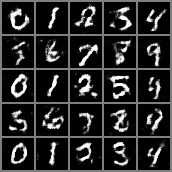


Epoch: 2/20, batch: 469/469, G_loss: 1.5253772735595703, D_loss: 0.28555285930633545


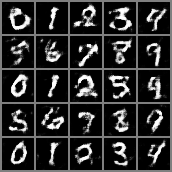


Epoch: 3/20, batch: 200/469, G_loss: 1.8473107814788818, D_loss: 0.36890435218811035


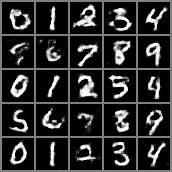


Epoch: 3/20, batch: 400/469, G_loss: 2.14266300201416, D_loss: 0.2837660014629364


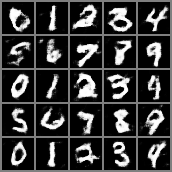


Epoch: 3/20, batch: 469/469, G_loss: 3.0812926292419434, D_loss: 0.25531572103500366


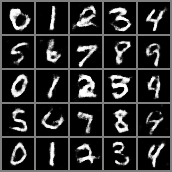


Epoch: 4/20, batch: 200/469, G_loss: 1.9521796703338623, D_loss: 0.26063504815101624


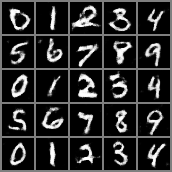


Epoch: 4/20, batch: 400/469, G_loss: 2.113736629486084, D_loss: 0.23205047845840454


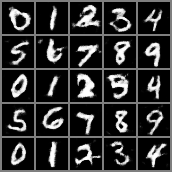


Epoch: 4/20, batch: 469/469, G_loss: 1.7908662557601929, D_loss: 0.1484796404838562


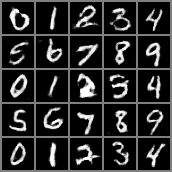


Epoch: 5/20, batch: 200/469, G_loss: 2.957408905029297, D_loss: 0.29831090569496155


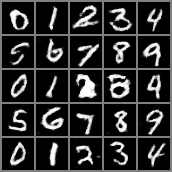


Epoch: 5/20, batch: 400/469, G_loss: 2.532485008239746, D_loss: 0.0923808142542839


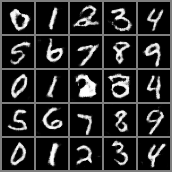


Epoch: 5/20, batch: 469/469, G_loss: 2.375927448272705, D_loss: 0.10141406953334808


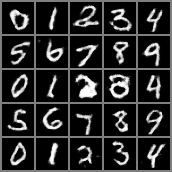


Epoch: 6/20, batch: 200/469, G_loss: 3.7410411834716797, D_loss: 0.06225387379527092


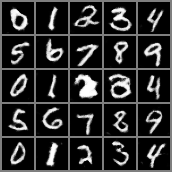


Epoch: 6/20, batch: 400/469, G_loss: 3.09014892578125, D_loss: 0.049944374710321426


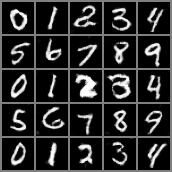


Epoch: 6/20, batch: 469/469, G_loss: 4.318643569946289, D_loss: 0.05750220641493797


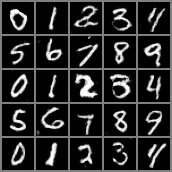


Epoch: 7/20, batch: 200/469, G_loss: 4.035309314727783, D_loss: 0.02252802439033985


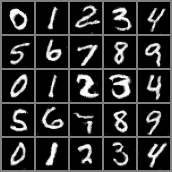


Epoch: 7/20, batch: 400/469, G_loss: 5.6591949462890625, D_loss: 0.017444130033254623


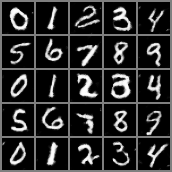


Epoch: 7/20, batch: 469/469, G_loss: 4.103754043579102, D_loss: 0.0168423093855381


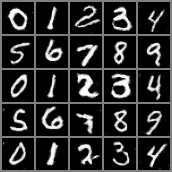


Epoch: 8/20, batch: 200/469, G_loss: 3.036993980407715, D_loss: 0.5407435297966003


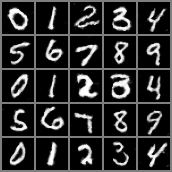


Epoch: 8/20, batch: 400/469, G_loss: 5.069684982299805, D_loss: 0.031746380031108856


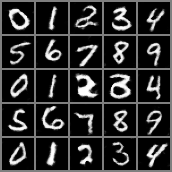


Epoch: 8/20, batch: 469/469, G_loss: 5.3034210205078125, D_loss: 0.0139237679541111


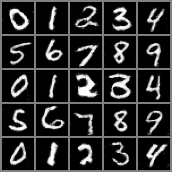


Epoch: 9/20, batch: 200/469, G_loss: 5.13899040222168, D_loss: 0.011514418758451939


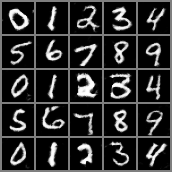


Epoch: 9/20, batch: 400/469, G_loss: 6.428421974182129, D_loss: 0.004434412345290184


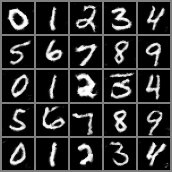


Epoch: 9/20, batch: 469/469, G_loss: 4.586315155029297, D_loss: 0.010670933872461319


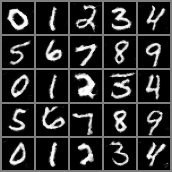


Epoch: 10/20, batch: 200/469, G_loss: 5.392761707305908, D_loss: 0.005069435574114323


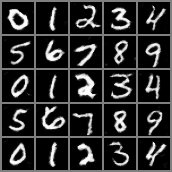


Epoch: 10/20, batch: 400/469, G_loss: 5.412711143493652, D_loss: 0.009525973349809647


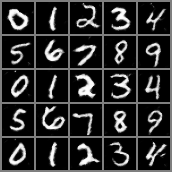


Epoch: 10/20, batch: 469/469, G_loss: 6.207273006439209, D_loss: 0.0034088557586073875


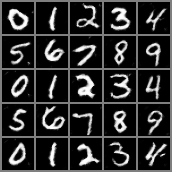


Epoch: 11/20, batch: 200/469, G_loss: 6.883998870849609, D_loss: 0.0029786089435219765


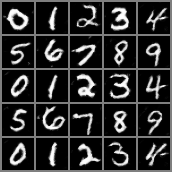


Epoch: 11/20, batch: 400/469, G_loss: 2.196688175201416, D_loss: 0.8311899304389954


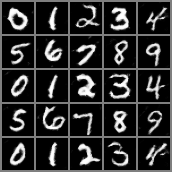


Epoch: 11/20, batch: 469/469, G_loss: 1.8804454803466797, D_loss: 0.39205437898635864


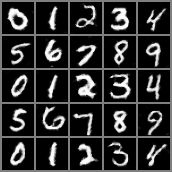


Epoch: 12/20, batch: 200/469, G_loss: 2.2660608291625977, D_loss: 0.2564886808395386


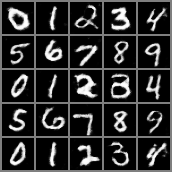


Epoch: 12/20, batch: 400/469, G_loss: 5.215571403503418, D_loss: 0.02039007842540741


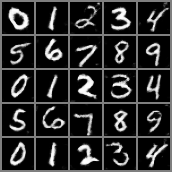


Epoch: 12/20, batch: 469/469, G_loss: 1.7247109413146973, D_loss: 0.21349428594112396


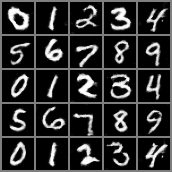


Epoch: 13/20, batch: 200/469, G_loss: 5.196119785308838, D_loss: 0.005890584085136652


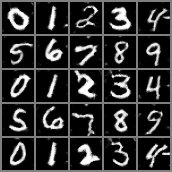


Epoch: 13/20, batch: 400/469, G_loss: 5.120477199554443, D_loss: 0.005556334741413593


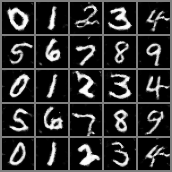


Epoch: 13/20, batch: 469/469, G_loss: 6.33053731918335, D_loss: 0.005909851286560297


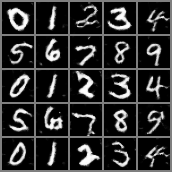

In [ ]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
labels_cycle = cycle(range(hparams['num_classes']))
labels_val = torch.tensor([next(labels_cycle) for i in range(hparams['num_val_samples'])],
                          device=device).unsqueeze(1) #the labels will be a cycle from 0 to 9

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, real_classes) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        real_classes = real_classes.unsqueeze(1).to(device)
        loss_g, loss_d = train_batch_conditional(
            real_samples,
            real_classes,
            generator,
            discriminator,
            optimizer_g,
            optimizer_d,
        )

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  + f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate_conditional(generator, z_val, labels_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)}, "
          + f"G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate_conditional(generator, z_val, labels_val)
    display(fake_images)


### Conditional generation

In [ ]:
#You can play and visualize different numbers
number_chosen = 3
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
number_chosen_torch = torch.tensor([
        number_chosen for i in range(hparams['num_val_samples'])
    ],
    device=device).unsqueeze(1)

images_number_chosen = evaluate_conditional(generator, z_val, number_chosen_torch)
display(images_number_chosen)

# Task
Complete the `ConditionalGenerator` class in cell `Y4XFfu-BHQli` by initializing `self.fc` with `nn.Linear(noise_size, 512 * 4 * 4)`, `self.convt1` with input channels `512 + 1`, `self.convt2` with input channels `256`, and `self.convt3` with input channels `128` and output channels `num_input_channels`. Implement the `forward` method to reshape `x` to `(B, 512, 4, 4)`, get the label embedding `emb` (reshaped to `(B, 1, 4, 4)`) using `self.embedding(label.squeeze(1))`, concatenate `x` and `emb` along dimension 1, and then pass the result through the `convt` blocks.
Complete the `ConditionalDiscriminator` class in cell `LVqJA2kuHQlj` by initializing `self.conv1` with input channels `num_input_channels + 1`, `self.conv2` with input channels `128`, `self.conv3` with input channels `256`, and `self.fc` with input size `512 * 4 * 4` and output `1`. Implement the `forward` method to get the label embedding `emb` (reshaped to `(B, 1, 32, 32)`) using `self.embedding(label.squeeze(1))`, concatenate `x` and `emb` along dimension 1, pass the result through the `conv` blocks, reshape to `(B, -1)`, and then pass through the `fc` layer.
Complete the `train_batch_conditional` function in cell `vZT8H_B8HQlj` by defining `label_real` as `torch.ones(bsz, 1)` and `label_fake` as `torch.zeros(bsz, 1)`.
Finally, summarize all the completed code modifications for the conditional GAN section.

## Complete ConditionalGenerator

### Subtask:
Complete the `ConditionalGenerator` class in cell `Y4Xfu-BHQli`. This involves initializing `self.fc` and the three `ConvTranspose2d` blocks with the correct input/output channels (considering the concatenated embedding), and implementing the `forward` method to reshape and concatenate the label embedding.


**Reasoning**:
The subtask requires completing the `ConditionalGenerator` class by filling in the `__init__` and `forward` methods according to the provided instructions. This involves defining the fully connected layer, adjusting the convolutional layer input/output channels, and implementing the concatenation logic for the label embedding in the forward pass.



In [ ]:
class ConditionalGenerator(torch.nn.Module):

    def __init__(
            self,
            noise_size: int,
            num_input_channels: int,
            num_classes: int
            ) -> None:

        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 4 * 4)

        # Embedding of the class
        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=4*4,
        )

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 1, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(x.shape[0], 512, 4, 4) # (B, channels, height, width)
        emb = self.embedding(label.squeeze(1)).reshape(-1, 1, 4, 4) # (B, 1, height, width)
        x = torch.cat((x, emb), dim=1)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

## Complete ConditionalDiscriminator

### Subtask:
Complete the `ConditionalDiscriminator` class in cell `LVqJA2kuHQlj`. This involves initializing the three `Conv2d` blocks with the correct input/output channels (considering the concatenated embedding), and implementing the `forward` method to reshape and concatenate the label embedding before passing it through the convolutional layers and the final fully connected layer.


**Reasoning**:
The subtask requires completing the `ConditionalDiscriminator` class by correctly initializing its layers and implementing the forward pass according to the specified concatenation logic for the label embedding.



In [ ]:
class ConditionalDiscriminator(torch.nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 num_classes: int):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=32*32,
        )

        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels + 1, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        B = x.size(0)
        emb = self.embedding(label.squeeze(1)).reshape(B, 1, 32, 32) # (B, 1, 32, 32)
        x = torch.cat((x, emb), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(B, -1) # (B, channels * height * width)
        x = self.fc(x)

        return x

**Reasoning**:
The subtask requires completing the `train_batch_conditional` function by defining the `label_real` and `label_fake` tensors as per the instructions.



In [ ]:
def train_batch_conditional(
        real_samples: torch.Tensor,
        real_classes: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_classes = torch.randint(0, 10, size=(bsz, 1), device=device)
    fake_samples = generator(z, fake_classes)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights (do a step in the optimizer)
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach() # Let's detach them to freeze the generator

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward()

    # Update weights (do a step in the optimizer)
    optimizer_d.step()

    return loss_g.item(), loss_d.item()

## Summary of Completed Code Modifications for Conditional GAN

### `ConditionalGenerator` Class (`Y4XFfu-BHQli`)
- **`__init__` method**:
    - `self.fc` was initialized with `nn.Linear(noise_size, 512 * 4 * 4)`.
    - `self.convt1`'s input channels were set to `512 + 1`.
    - `self.convt2`'s input channels were set to `256`.
    - `self.convt3`'s input channels were set to `128` and output channels to `num_input_channels`.
- **`forward` method**:
    - `x` was reshaped to `(B, 512, 4, 4)`.
    - The label embedding `emb` was obtained using `self.embedding(label.squeeze(1))` and reshaped to `(B, 1, 4, 4)`.
    - `x` and `emb` were concatenated along dimension 1.
    - The concatenated tensor was passed through `self.convt1`, `self.convt2`, and `self.convt3`.

### `ConditionalDiscriminator` Class (`LVqJA2kuHQlj`)
- **`__init__` method**:
    - `self.conv1`'s input channels were set to `num_input_channels + 1` and output channels to `128`.
    - `self.conv2`'s input channels were set to `128` and output channels to `256`, including `BatchNorm2d(256)`.
    - `self.conv3`'s input channels were set to `256` and output channels to `512`, including `BatchNorm2d(512)`.
    - `self.fc` was initialized with an input size of `512 * 4 * 4` and an output size of `1`.
- **`forward` method**:
    - The label embedding `emb` was obtained using `self.embedding(label.squeeze(1))` and reshaped to `(B, 1, 32, 32)`.
    - `x` and `emb` were concatenated along dimension 1.
    - The concatenated tensor was passed through `self.conv1`, `self.conv2`, and `self.conv3`.
    - The output was reshaped to `(B, -1)`.
    - The reshaped tensor was passed through `self.fc`.

### `train_batch_conditional` Function (`vZT8H_B8HQlj`)
- `label_real` was defined as `torch.ones(bsz, 1)`.
- `label_fake` was defined as `torch.zeros(bsz, 1)`.

## Summary:

### Data Analysis Key Findings

The task involved completing three components for a Conditional Generative Adversarial Network (CGAN): the `ConditionalGenerator` class, the `ConditionalDiscriminator` class, and the `train_batch_conditional` function. All specified modifications were successfully implemented.

*   **`ConditionalGenerator` Class:**
    *   `self.fc` was initialized as `nn.Linear(noise_size, 512 * 4 * 4)`.
    *   The convolutional transpose layers were configured to integrate the conditional label:
        *   `self.convt1`'s input channels were set to `512 + 1` (to account for the concatenated label embedding).
        *   `self.convt2`'s input channels were `256`.
        *   `self.convt3`'s input channels were `128` and output channels were `num_input_channels`.
    *   The `forward` method correctly reshaped the noise vector `x` to `(B, 512, 4, 4)`, created a label embedding `emb` of shape `(B, 1, 4, 4)`, and concatenated `x` and `emb` along dimension 1 before passing them through the transposed convolutions.

*   **`ConditionalDiscriminator` Class:**
    *   The convolutional layers were configured to integrate the conditional label:
        *   `self.conv1`'s input channels were set to `num_input_channels + 1` (to account for the concatenated label embedding).
        *   `self.conv2`'s input channels were `128`.
        *   `self.conv3`'s input channels were `256`.
    *   `self.fc` was initialized with an input size of `512 * 4 * 4` and an output size of `1`.
    *   The `forward` method correctly created a label embedding `emb` of shape `(B, 1, 32, 32)`, concatenated the input `x` and `emb` along dimension 1, passed the result through the convolutional blocks, reshaped the output to `(B, -1)`, and finally passed it through the fully connected layer.

*   **`train_batch_conditional` Function:**
    *   `label_real` was correctly defined as a `torch.ones(bsz, 1)` tensor.
    *   `label_fake` was correctly defined as a `torch.zeros(bsz, 1)` tensor.

### Insights or Next Steps

*   The successful implementation of these components establishes the foundational architecture for training a Conditional GAN, allowing the model to generate images based on specific class labels.
*   The next logical step is to verify the training stability and performance of the CGAN using these completed components, and potentially fine-tune hyperparameters for optimal image generation quality and mode collapse prevention.
